# Qamomile v0.8.0

---

This release significantly enhances accessibility for a broader audience by adding [tutorials in Japanese](https://jij-inc.github.io/Qamomile/ja/) (including a new tutorial for Bloqade-Analog), improves usability by supporting [OMMX v2](https://jij-inc.github.io/ommx/en/introduction.html), and introduces support for the new quantum SDK [CUDA-Q](https://developer.nvidia.com/cuda-q). We have also added support for [Qiskit](https://github.com/Qiskit/qiskit) v2. We believe that OMMX v2 support is especially significant for both us and our users, as OMMX allows us to compare quantum optimization algorithms and classical solvers more easily than before by providing a unified format for optimization problems.

We have other updates with slightly smaller impacts as well. Please have a look at our [releases](https://github.com/Jij-Inc/Qamomile/releases) and individual PRs for more details.

## ✨ New Features

### OMMX v2 Support ([#126](https://github.com/Jij-Inc/Qamomile/pull/126), [#198](https://github.com/Jij-Inc/Qamomile/pull/198))

OMMX v2 brings major performance improvements through a new Rust-based implementation, replacing the previous Protocol Buffer-based approach (see [OMMX Python SDK 2.0.0](https://github.com/Jij-Inc/ommx/blob/main/docs/en/release_note/ommx-2.0.0.md) for more details). This update provides:

  - **Enhanced Performance**: Computational complexity improvements, especially for large-scale problems
  - **Improved API**: More intuitive and AI-friendly API design
  - **Better Type Safety**: Rust-level type checking for more robust optimization problem handling

Note that OMMX v2 brings performance improvements in handling instances, but it does not bring performance improvements on the quantum algorithm side, such as circuit running time.

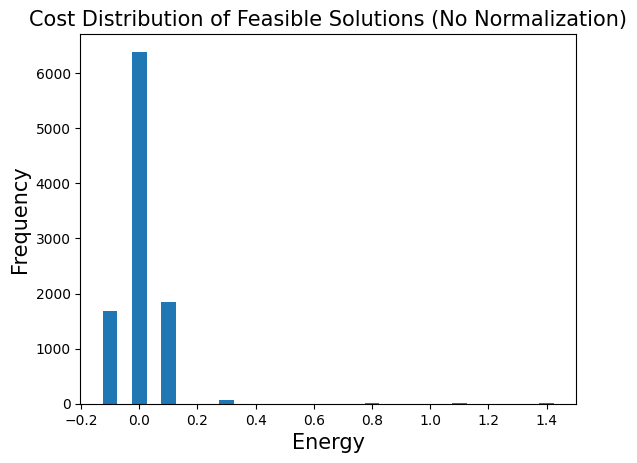

In [1]:
# Import necessary libraries.
from collections import defaultdict

import jijmodeling as jm
import matplotlib.pyplot as plt
import numpy as np
import ommx.v1
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

import qamomile.core as qm
import qamomile.qiskit as qm_qk


# Create optimization problem with JijModeling.
Q = jm.Placeholder("Q", ndim=2)
n = Q.len_at(0, latex="n")
x = jm.BinaryVar("x", shape=(n,))

problem = jm.Problem("qubo")
i, j = jm.Element("i", n), jm.Element("j", n)
problem += jm.sum([i, j], Q[i, j] * x[i] * x[j])

# Compile with data as ommx.v1.Instance.
instance_data = {"Q": [[0.1, 0.2, -0.1], [0.2, 0.3, 0.4], [-0.1, 0.4, 0.0]]}
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)  # NEW

# Convert to QAOA using Qamomile.
qaoa_converter = qm.qaoa.QAOAConverter(instance)
p = 5
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

# Convert Qamomile circuit and Hamiltonian to Qiskit format.
qk_transpiler = qm_qk.QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

# Define cost estimation function using Qiskit primitives.
estimator = qk_pr.StatevectorEstimator()
cost_history = []
def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"Error during cost estimation: {e}")
        return np.inf

# Optimise the QAOA parameters using COBYLA.
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000, "tol": 1e-2},
)

# Run the QAOA circuit with the optimised parameters.
qk_circuit.measure_all()
sampler = qk_pr.StatevectorSampler()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
sampleset: ommx.v1.SampleSet = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])  # NEW

# Create a dictionary to group energies and count their frequencies.
energy_freq = defaultdict(int)
for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq[sample.objective] += 1
energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

# Show the cost distribution.
plt.bar(energies, frequencies, width=0.05)
plt.title("Cost Distribution of Feasible Solutions (No Normalization)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

### CUDA-Q Support ([#143](https://github.com/Jij-Inc/Qamomile/pull/143))
CUDA-Q streamlines hybrid application development and promotes productivity and scalability in quantum computing. Now, you can compile your circuits and Hamiltonians in Qamomile format into CUDA-Q format!

Please note that since CUDA-Q currently supports only Linux OS, Qamomile's CUDA-Q support functionality is also limited to Linux OS only.

In [2]:
import cudaq

from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.operator import Hamiltonian, X, Y, Z
from qamomile.cudaq.transpiler import CudaqTranspiler

# Create an instance of the CudaqTranspiler.
cudaq_transpiler = CudaqTranspiler()

# Define a simple quantum circuit using Qamomile.
qc = QamomileCircuit(1)
qc.h(0)
qc.x(0)

# Transpile the circuit using CudaqTranspiler.
transpiled_circuit = cudaq_transpiler.transpile_circuit(qc)

# Draw the transpiled circuit.
print(type(transpiled_circuit))
print(cudaq.draw(transpiled_circuit, []))

# Create a Hamiltonian using Qamomile.
hamiltonian = Hamiltonian()
hamiltonian += X(0) * Z(1)
hamiltonian += Y(0) * Y(1) * Z(2) * X(3) * X(4)

# Transpile the Hamiltonian using CudaqTranspiler.
transpiled_hamiltonian = cudaq_transpiler.transpile_hamiltonian(hamiltonian)
# Show the transpiled hamiltonian.
print(type(transpiled_hamiltonian))
print(transpiled_hamiltonian)

<class 'cudaq.kernel.kernel_builder.PyKernel'>
     ╭───╮╭───╮
q0 : ┤ h ├┤ x ├
     ╰───╯╰───╯

<class 'cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.SpinOperator'>
(0+0i) + (1+0i) * X0Z1 + (1+0i) * Y0Y1Z2X3X4


### Qiskit v2 Support ([#194](https://github.com/Jij-Inc/Qamomile/pull/194))
Following Qiskit's major update, Qamomile now supports Qiskit v2.

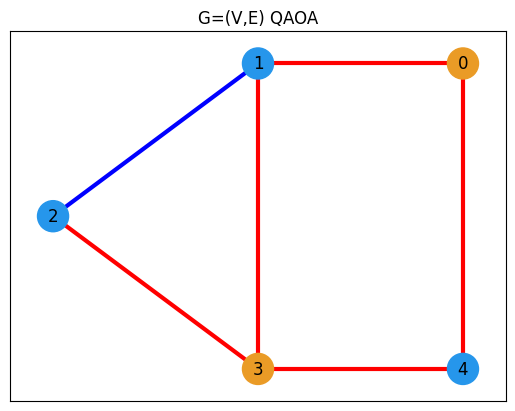

In [3]:
# Import necessary libraries
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.qiskit.transpiler import QiskitTranspiler

# Define Maxcut problem
V = jm.Placeholder("V")
E = jm.Placeholder("E", ndim=2)
x = jm.BinaryVar("x", shape=(V,))
e = jm.Element("e", belong_to=E)
i = jm.Element("i", belong_to=V)
j = jm.Element("j", belong_to=V)

problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
si = 2 * x[e[0]] - 1
sj = 2 * x[e[1]] - 1
si.set_latex("s_{e[0]}")
sj.set_latex("s_{e[1]}")
obj = 1 / 2 * jm.sum(e, (1 - si * sj))
problem += obj

# Compile the problem as ommx.v1.Instance with data
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
E = [list(edge) for edge in G.edges]
instance_data = {"V": G.number_of_nodes(), "E": E}
compiled_instance: ommx.v1.Instance = jm.Interpreter(instance_data).eval_problem(problem)

# Convert the compiled problem to QAOA format
qaoa_converter = QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

# Get QAOA Hamiltonian and circuit
p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

# Convert QAOA circuit and Hamiltonian for Qiskit
transpiler = QiskitTranspiler()
qk_circuit = transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)

# Cost estimation function
cost_history = []
estimator = qk_pr.StatevectorEstimator()
def estimate_cost(param_values):
   try:
       job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
       result = job.result()[0]
       cost = result.data.evs  # Qiskit v2 recommended access method
       cost_history.append(cost)
       return cost
   except Exception as e:
       print(f"Error during cost estimation: {e}")
       return np.inf

# Execute QAOA optimization
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)
result = minimize(
   estimate_cost,
   initial_params,
   method="COBYLA",
   options={"maxiter": 2000},
)

# Run the optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
qaoa_counts = job_result.data.meas  # Qiskit v2 recommended access method

# Get the optimal solution
sampleset = qaoa_converter.decode(transpiler, qaoa_counts)
best_values = sampleset.best_feasible_unrelaxed.extract_decision_variables("x")

# Get edge colors and node colors
def get_edge_colors(graph, cut_solution, in_cut_color="r", not_in_cut_color="b"):
   cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
   cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]
   
   edge_colors = []
   for u, v, _ in graph.edges(data=True):
       if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
           edge_colors.append(in_cut_color)
       else:
           edge_colors.append(not_in_cut_color)
   node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in G.nodes()]
   return edge_colors, node_colors

edge_colors, node_colors = get_edge_colors(G, best_values)

# Draw the graph
pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(G, pos, node_size=500, width=3, with_labels=True, edge_color=edge_colors, node_color=node_colors)

## 🐛 Bug Fixes

See our [releases](https://github.com/Jij-Inc/Qamomile/releases) for details.

## 🛠️ Other Changes and Improvements

See our [releases](https://github.com/Jij-Inc/Qamomile/releases) for details.

## 💬 Feedback
With these new features, Qamomile becomes a powerful tool for enabling users to access several quantum SDKs in the same way and compare the results with classical solvers. Try out Qamomile 0.8.0!


Please submit any feedback or bug reports to [GitHub Issues](https://github.com/Jij-Inc/Qamomile/issues).